# Character Predicting with RNN
---

Codes are writen by simonjisu.
* Simonjisu Blog: https://simonjisu.github.io
* Project Numpy with NN: https://github.com/simonjisu/NUMPYwithNN



## Goal
Writing 'Hello world! Nice to meet you! I love iron-man' using RNN with numpy

|Input||Output|
|:-:|:-:|:-:|
|h|$\rightarrow$|e|
|e|$\rightarrow$|l|
|l|$\rightarrow$|l|
|l|$\rightarrow$|o|
|$\vdots$|$\vdots$|$\vdots$|
|m|$\rightarrow$|a|
|a|$\rightarrow$|n|


## Packages

In [1]:
import os
import sys
dir_path = '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(dir_path)

In [2]:
import numpy as np
from common.SimpleRNN import Single_layer_RNN
from common.optimizer import Adam
from common.train_graph import loss_graph
np.random.seed(1234)

## DATA

In [3]:
x = 'hello world! nice to meet you! i love iron-man'

### Encoder

In [4]:
class chr_coding(object):
    def __init__(self):
        self._dict = None
        self._one_hot_matrix = None
        self._dict_reversed = None
        
    def fit(self, x):
        if isinstance(x, str):
            x = list(x)
        
        self._one_hot_matrix = np.eye(len(set(x)))
        self._dict = {d: i for i, d in enumerate(list(set(x)))}
        self._dict_reversed = {v: k for k, v in self._dict.items()}
        
    def encode(self, x):
        encoded_data = np.array([self._one_hot_matrix[self._dict[d]] for d in x])
        return encoded_data
    
    def decode(self, x, probs=None):
        if probs is None:
            decoded_data = self._dict_reversed[x]
        else:
            decoded_data = self._dict_reversed[np.argmax(probs)]
        return decoded_data

Change our data to one-hot encoding data by single character. 

In [5]:
encoder = chr_coding()
encoder.fit(x)
one_hot_data = encoder.encode(x)

print('data shape:', one_hot_data.shape)

data shape: (46, 19)


## Parameters

In [6]:
NUM_EPOCHS = 600
PRINT_EPOCH = 30
INPUT_SIZE = one_hot_data.shape[1]
OUTPUT_SIZE = one_hot_data.shape[1]
HIDDEN_SIZE = 20
BPTT_TRUNCATE = 5 
# Backpropagation Through Time Truncate: 
# A fixed number of steps to lookback past data in BPTT

## Get Training Datas

In [7]:
train_x = one_hot_data[:-1]
train_y = one_hot_data[1:]

## Call RNN module & Optimizer Setting

Basic Settings of **Single_layer_RNN**

* input_size: input layer size
* hidden_size: hidden layer size
* output_size: output layer size
* bptt_truncate: if you want to use it, use backward_truncate method when you doing backward, default=0
* activation_func: if use "tanh", params will initialize as Xavier, use "relu", initialize as He, default="tanh"

In [8]:
# accuracy calculation function
def get_accuracy(x, test_string):
    bool_ = np.array(list(x))[1:] == np.array(list(test_string))[1:]
    return bool_.sum() / len(bool_)

In [9]:
def train(rnn, optim, option=True, print_epoch=20):
    """
    option:
    * True: do backward
    * False: do backward_truncate
    """
    total_loss_list = []
    total_acc_list = []
    for epoch in range(NUM_EPOCHS):
        test_string = 'h'
        # forward
        total_loss = rnn.loss(train_x, train_y)

        # backward
        if option:
            rnn.backward()
        else:
            rnn.backward_truncate()

        optim.update(rnn.params, rnn.params_summ)

        # test string
        predicted_idx = rnn.predict(train_x)
        for idx in predicted_idx:
            test_string += encoder.decode(idx)

        # get accuracy
        acc = get_accuracy(x, test_string)

        if epoch % print_epoch == 0:
            print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
                  .format(epoch, total_loss, acc, test_string))
        elif epoch == (NUM_EPOCHS-1):
            print('#{0}, Loss: {1:.6f}, Acc: {2:.6f}, Test_string: "{3}"'\
                  .format(epoch, total_loss, acc, test_string))

        total_loss_list.append(total_loss)
        total_acc_list.append(acc)
    return total_loss_list, total_acc_list

### Using BPTT

In [10]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE)
optim = Adam()

In [11]:
total_loss_list, total_acc_list = train(rnn, optim, option=True, print_epoch=PRINT_EPOCH)

#0, Loss: 2.998886, Acc: 0.044444, Test_string: "hw dirw-ococmctladidoummlviceilucctolmmd-oomm-"
#30, Loss: 2.602309, Acc: 0.244444, Test_string: "hw riowoommmttolm ioowmmlvooemdi oodmmioodume-"
#60, Loss: 2.294527, Acc: 0.444444, Test_string: "hw ii woomd!toolm toomee vooumdi oodm ioooemei"
#90, Loss: 2.027362, Acc: 0.511111, Test_string: "hw li woome!tooce toomee  oocmdi oole ioooemei"
#120, Loss: 1.764794, Acc: 0.644444, Test_string: "hw l  woole! ooce toomee  oocm i iove ioooeman"
#150, Loss: 1.512159, Acc: 0.733333, Test_string: "hw l  woold! ooce toomeet iou! i iove ioooeman"
#180, Loss: 1.286389, Acc: 0.800000, Test_string: "hell  world! ooce tooleet iou! i iove iooo-man"
#210, Loss: 1.088872, Acc: 0.866667, Test_string: "hello world! ooce tooleet iou! i love ioon-man"
#240, Loss: 0.918694, Acc: 0.911111, Test_string: "hello world! ooce to leet you! i love ioon-man"
#270, Loss: 0.772422, Acc: 0.955556, Test_string: "hello world! noce to meet you! i love ioon-man"
#300, Loss: 0.6

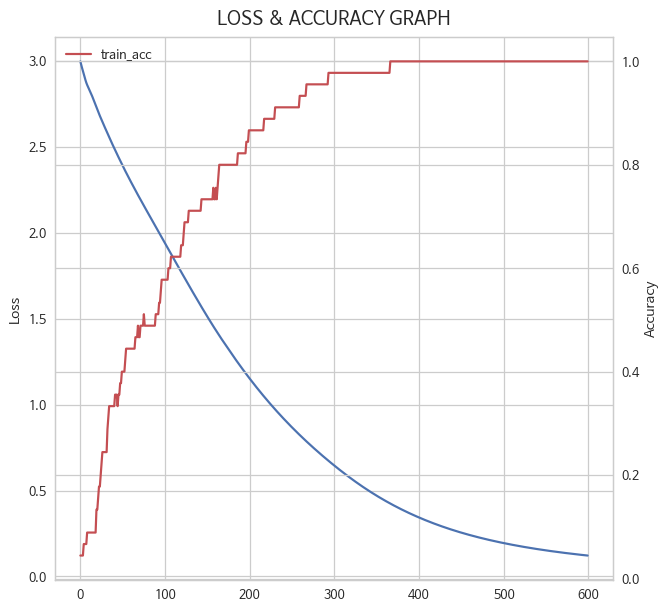

In [12]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

### Using BPTT-Truncate

In [13]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE,
                       bptt_truncate=BPTT_TRUNCATE)
optim = Adam()

In [14]:
total_loss_list, total_acc_list = train(rnn, optim, option=False, print_epoch=PRINT_EPOCH)

#0, Loss: 2.998435, Acc: 0.066667, Test_string: "haid c!ryha-a ovcncoirha ocieha    ey-i aehc! "
#30, Loss: 2.753608, Acc: 0.111111, Test_string: "hai  cyrema   ol o oeyra ooiel     enii aeoc! "
#60, Loss: 2.543146, Acc: 0.155556, Test_string: "hai    ee     o    oe    oo e        o  oeo   "
#90, Loss: 2.338653, Acc: 0.222222, Test_string: "hai   orr!!   oo   oeee  ooee    o e ii oeo ! "
#120, Loss: 2.142541, Acc: 0.355556, Test_string: "hal   orrl!   oe   oeee  oooe    ooe  i oe!m! "
#150, Loss: 1.948652, Acc: 0.466667, Test_string: "hml   orrl!   oe   ooee   ooe!   ooe  ioon-ma "
#180, Loss: 1.781490, Acc: 0.488889, Test_string: "hml   orrl!   oe   ooee   ooe!   ooe  ioon-man"
#210, Loss: 1.642531, Acc: 0.511111, Test_string: "hml    rrl!   oe   ooee t ooe!   ooe  ioon-man"
#240, Loss: 1.514889, Acc: 0.555556, Test_string: "hmll  orrl!!  oe   ooee t ooe!   ooe  ioon-man"
#270, Loss: 1.392981, Acc: 0.666667, Test_string: "hmllo orrl!!  oe   ooee t you! i  oe  iron-man"
#300, Loss: 1.2

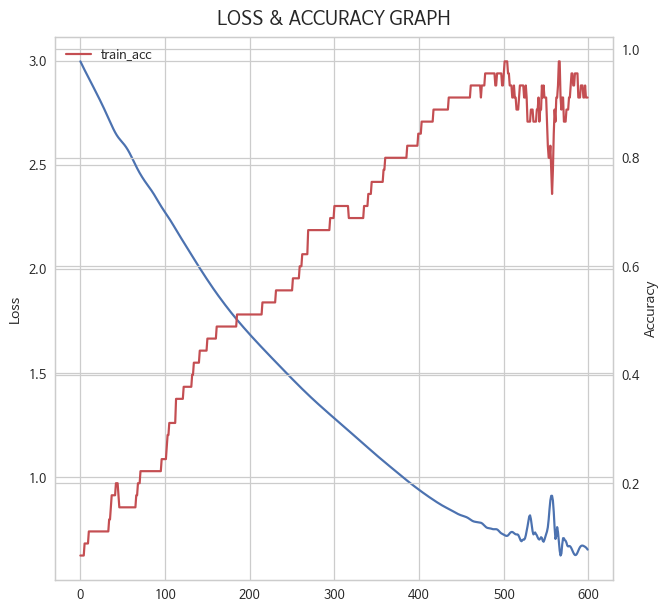

In [15]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)

### Using ReLu as activation functions

In [16]:
rnn = Single_layer_RNN(input_size=INPUT_SIZE, 
                       hidden_size=HIDDEN_SIZE, 
                       output_size=OUTPUT_SIZE,
                       bptt_truncate=BPTT_TRUNCATE,
                       activation_func='relu')
optim = Adam()

In [17]:
total_loss_list, total_acc_list = train(rnn, optim, option=True, print_epoch=PRINT_EPOCH)

#0, Loss: 5.872600, Acc: 0.066667, Test_string: "hl--diuuaauiinniimiuininiuiiiuinniuiuuiuuuuiin"
#30, Loss: 3.115769, Acc: 0.088889, Test_string: "hl--d-devadh-tnlimeo-dehhenm-diem-e-hiemeen-vn"
#60, Loss: 2.939246, Acc: 0.088889, Test_string: "hl--d-neaadh-onlimeo-demnenm-dielee-iiemeennvn"
#90, Loss: 2.787358, Acc: 0.088889, Test_string: "hl-ed-oeaadheonlimnovoelnenmvdielee-iieleennvn"
#120, Loss: 2.648900, Acc: 0.111111, Test_string: "hliedioeaadheonlionovoeonenotdeoleeeieeoednnvn"
#150, Loss: 2.512976, Acc: 0.177778, Test_string: "hliedeoeaadleonleotovoeonenotdeoleeeieeoednnan"
#180, Loss: 2.368250, Acc: 0.266667, Test_string: "hllloeoeaadleonmeotovoeonenotoeelleeoeeoeonnan"
#210, Loss: 2.195440, Acc: 0.333333, Test_string: "hllloeo radoeonmeotovoeononotoei leeoeeoeonnan"
#240, Loss: 1.981370, Acc: 0.422222, Test_string: "hllloee radoeo meoto oeot notoei leeoeo ennnan"
#270, Loss: 1.750575, Acc: 0.555556, Test_string: "hlllo e radoen meoto me   yo o i leeo i lnnnan"
#300, Loss: 1.5

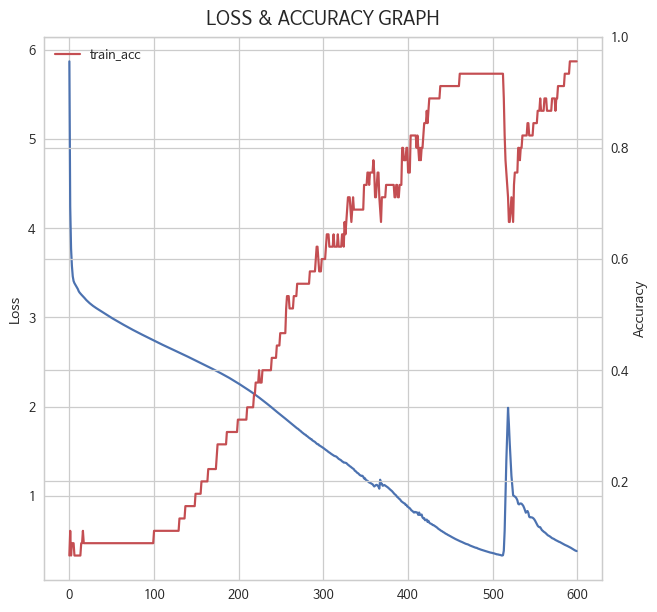

In [18]:
loss_graph(train_loss_list=total_loss_list, train_acc_list=total_acc_list)